# Installs

In [8]:
!pip install rouge-score
!pip uninstall -y wandb
!pip install openpyxl
!pip install camel-tools

# Libraries

In [9]:
import re
import ast
import torch
import tokenizers
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments, AutoTokenizer, T5Tokenizer, MT5ForConditionalGeneration, MT5Tokenizer, EarlyStoppingCallback

# NER
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.utils.charsets import AR_LETTERS_CHARSET
from camel_tools.morphology.analyzer import Analyzer
from camel_tools.ner import NERecognizer
# POS tagging
# from camel_tools.morphology.disambiguator import Disambiguator


# Reading Data

In [71]:
df_squad = pd.read_excel('/kaggle/input/arabic-squad-data/Arabic-SQuAD.xlsx')
print("squad data loaded")
# df_arcd = pd.read_excel('ARCD/arcd-train.xlsx')
# print("arcd data loaded")
# df_tydiqa = pd.read_csv('tydiqa/tydiqa-arabic.csv')
# print("tydiqa data loaded")
# df_mlqa = pd.read_excel('MLQA/MLQA-dev-context-ar-question-ar.xlsx')
# print("mlqa data loaded")

squad data loaded


# Data Overview

In [72]:
df_squad.head()

,id,question,context,answers,c_id
0,570bce516b8089140040fa42,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0
1,570bce516b8089140040fa43,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0
2,570bce516b8089140040fa44,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0
3,570bce516b8089140040fa45,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0
4,570bce516b8089140040fa46,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0


In [73]:
df_squad.shape

(48344, 5)

In [74]:
# df_arcd.head()

In [75]:
# df_arcd.shape

In [76]:
# df_tydiqa.head()

In [77]:
# df_tydiqa.shape

In [78]:
# df_mlqa.head()

In [79]:
# df_mlqa.shape

In [80]:
df_squad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48344 entries, 0 to 48343
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48344 non-null  object
 1   question  48344 non-null  object
 2   context   48344 non-null  object
 3   answers   48344 non-null  object
 4   c_id      48344 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [81]:
# df_arcd.info()

In [82]:
# df_tydiqa.info()

In [83]:
# df_mlqa.info()

# Removing id column

In [84]:
# TODO: Removing ids column in all datasets

In [85]:
df_squad.drop('id', axis=1, inplace=True)

In [86]:
df_squad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48344 entries, 0 to 48343
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  48344 non-null  object
 1   context   48344 non-null  object
 2   answers   48344 non-null  object
 3   c_id      48344 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [87]:
df_squad.head(10)

,question,context,answers,c_id
0,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0
1,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0
2,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0
3,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0
4,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0
5,لماذا تم ترميز الرمز بحيث تكون معظم الرموز معًا؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': 'لسهولة تحديد الهوية', 'answer_start...",1
6,كم عدد المراكز في العمودين الأولين؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '32 موضع', 'answer_start': 128}]",1
7,ما الذي قررت اللجنة أنه مهم؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,[{'text': 'دعم الأحرف الهجائية الكبيرة المكونة...,1
8,أين كان الحرف ألف يضع في الموقف؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '41hex', 'answer_start': 757}]",1
9,تم دمج ASCII في ما مجموعة الأحرف الأخرى؟,تم دمج ASCII في مجموعة أحرف ونيكودي كأول 128 ر...,"[{'text': 'ونيكودي', 'answer_start': 28}]",2


# try1

tried to make something but found out it is the same as the original data

In [88]:
# # Assign a unique question_id to each question
# df_squad['question_id'] = df_squad.index

# # Function to get the context and its associated question_ids
# def get_context_question_ids(df):
#     grouped = df.groupby('c_id').agg(
#         context=('context', 'first'),
#         question_ids=('question_id', list)
#     ).reset_index()
#     return grouped

# # Generate the new DataFrame
# C_Q_df = get_context_question_ids(df_squad)

In [89]:
# C_Q_df.head(15)

In [90]:
# # Create a function to get the assigned questions
# def get_assigned_questions(df, c_id):
#     filtered = df[df['c_id'] == c_id]
#     Q = filtered['question'].tolist()
#     A = filtered['answers'].tolist()
#     return Q, A


In [91]:
# training_data = []

# for _, row in C_Q_df.iterrows():
#     context = row['context']
#     question_ids = row['question_ids']

#     # For each question_id in the context, fetch the corresponding question
#     for question_id in question_ids:
#         question = df_squad.loc[df_squad['question_id'] == question_id, 'question'].values[0]
#         training_data.append({
#             'context': context,
#             'question': question,
#             'answers': df_squad.loc[df_squad['question_id'] == question_id, 'answers'].values[0]
#         })

# training_df = pd.DataFrame(training_data)

In [92]:
# training_df.head(15)

In [93]:
# TODO: Arrange all data frames by their c_id column, to make same context after each other

In [94]:
# TODO: Combine all datasets as they already contain the same columns (pd.concat([df1, df2], ignore_index=True))

# Text Preprocessing

## text cleaning functions

### Normalization

In [95]:
def remove_diacritics(text):
    # remove diacritics from the text as it may confuse the model
    return re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)


### Text cleaning

In [96]:
def remove_non_arabic(text):
    # Remove non-Arabic characters, keeping essential punctuation
    text = re.sub(r'[^\u0600-\u06FF\s؟]', '', text)
    return text

In [97]:
def remove_punk(text):
    # Remove punctuation
    arabic_punctuation = r'[،؛؟…!"#$%&\'()*+,-./:;<=>@^_`{|}~]'
    text = re.sub(arabic_punctuation, '', text)
    return text

In [98]:
def remove_extra_spaces(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [99]:
def remove_alef_variations(text):
    text = re.sub(r'[إأٱآ]', 'ا', text)
    return text

### Handling numbers

In [100]:
def handle_numbers(text, replace_with=None):
    if replace_with:
        text = re.sub(r'\d+', replace_with, text)
    else:
        text = re.sub(r'\d+', '', text)
    return text

## Stop word removal

In [101]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [102]:
stop_words = set(stopwords.words('arabic'))
print(stop_words)

{'كي', 'ماذا', 'خلف', 'أحد', 'ؤ', 'رابع', 'أيضا', 'بضع', 'عن', 'أجمع', 'شين', 'ثالث', 'إياكما', 'بعض', 'كأيّن', 'إلَيْكَ', 'غداة', 'هبّ', 'إلى', 'تلكم', 'ما', 'وإذ', 'ز', 'وَيْ', 'إنا', 'مكانكنّ', 'خامس', 'كأيّ', 'بسّ', 'أجل', 'ا', 'أمد', 'تسعمائة', 'بك', 'نوفمبر', 'جمعة', 'سبعة', 'فمن', 'كلَّا', 'عين', 'ميم', 'تلكما', 'هَذِه', 'أولاء', 'تانِ', 'سبت', 'آنفا', 'وإن', 'مازال', 'ذا', 'يناير', 'هاته', 'عشرة', 'س', 'سبعمائة', 'هَاتانِ', 'له', 'ترك', 'لعل', 'آ', 'ذه', 'لكيلا', 'مهما', 'منها', 'تلقاء', 'تِي', 'دونك', 'أفعل به', 'كأنّ', 'اثني', 'صباح', 'ت', 'أسكن', 'إما', 'ممن', 'حمٌ', 'ماي', 'إليكن', 'أربعمئة', 'كم', 'أفٍّ', 'ليسا', 'ذلكن', 'أم', 'ف', 'منذ', 'بات', 'آناء', 'لسنا', 'خمسين', 'من', 'بعدا', 'ارتدّ', 'حيثما', 'أنّى', 'هَذا', 'هذا', 'أل', 'أنبأ', 'ستة', 'أربعة', 'زعم', 'صاد', 'خ', 'فيفري', 'تي', 'ة', 'اللذان', 'درهم', 'مذ', 'نفس', 'هنا', 'هذه', 'هنالك', 'دولار', 'ذان', 'هلم', 'كليكما', 'بها', 'كلّما', 'أنتم', 'ظاء', 'هما', 'ثمَّ', 'ط', 'مساء', 'خمس', 'ثمانمئة', 'هاكَ', 'آه', 'قرش',

In [103]:
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

## Sentence splitting

In [104]:
def split_sentences(text):
    sentences = re.split(r'[؟.!؟]', text)
    # Remove empty sentences and strip spaces
    return [sentence.strip() for sentence in sentences if sentence.strip()]

## Remove additional spaces between letters

In [105]:
def fix_arabic_spacing(text):
    # Reconnect ا to the previous word if it is fully isolated
    text = re.sub(r'(\S)\s+ا\s+', r'\1ا ', text)

    # Reconnect أ and ي to the next word if they are fully isolated
    text = re.sub(r'\s+أ\s+(\S)', r' أ\1', text)
    text = re.sub(r'\s+ي\s+(\S)', r' ي\1', text)

    # Normalize spaces (remove extra spaces)
    text = remove_extra_spaces(text)

    return text

![image.png](attachment:image.png)

## POS and NER

In [106]:
def preprocess_with_pos_ner(example):
    text = example["context"]

    # Get POS tags before cleaning
    pos_result = disambiguator.disambiguate(text)
    pos_tags = [word.analyses[0].pos for word in pos_result]

    # Get NER entities before cleaning
    ner_result = ner.predict(text)

    # Append POS and NER tags to context
    annotated_text = f"{text} | POS: {' '.join(pos_tags)} | NER: {ner_result}"
    
    return {"input_text": annotated_text, "target_text": example["question"]}

In [107]:
def clean_generated_text(text):
    # Remove POS tags (e.g., [POS:PROPN])
    text = re.sub(r'\[POS:[^\]]+\]', '', text)
    
    # Remove NER tags (e.g., [NER:PERSON])
    text = re.sub(r'\[NER:[^\]]+\]', '', text)
    
    # Remove extra spaces and trim
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Tokenization

In [108]:
!pip install SentencePiece 
import sentencepiece
print("SentencePiece version:", sentencepiece.__version__)

SentencePiece version: 0.2.0


### T5 tokenizer try

In [109]:
# Initialize T5 tokenizer
# tokenizer = T5Tokenizer.from_pretrained("mt5-small")

In [110]:
# # Example Arabic text
# text = "هذا نص تجريبي"

# # Tokenize the text
# encoded = tokenizer.tokenize(text)
# # encoded = tokenizer.convert_tokens_to_string(encoded)
# print("text after tokenize: ", encoded)

# # Tokenize the text without padding
# input_ids = tokenizer.encode(text, max_length=512, truncation=True, padding=False)
# print("Token IDs (no padding):", input_ids)

# # Decode token IDs back to text (skip special tokens)
# decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
# print("Decoded Text:", decoded_text)

In [111]:
# arabic_text = "هذا نص تجريبي"
# tokens = tokenizer.tokenize(arabic_text)
# print("Tokens:", tokens)

# # Check if any tokens are unknown
# unknown_tokens = [token for token in tokens if tokenizer.convert_tokens_to_ids(token) == 3]
# print("Unknown Tokens:", unknown_tokens)

# for token in tokens:
#     token_id = tokenizer.convert_tokens_to_ids(token)
#     print(f"Token: {token}, Token ID: {token_id}")

# vocab = tokenizer.get_vocab()
# print("Vocabulary Size:", len(vocab))

# # Check if some Arabic tokens exist in the vocabulary
# arabic_tokens = ["ه", "ذا", "نص", "تجريبي"]
# for token in arabic_tokens:
#     if token in vocab:
#         print(f"Token '{token}' found in vocabulary with ID: {vocab[token]}")
#     else:
#         print(f"Token '{token}' NOT found in vocabulary.")

after trying t5 tokenizer (small), it seems that this model has not trained enough on arabic words, it doesn't recognize it

### Compare between MT5 and AraBert

In [112]:
# from transformers import AutoTokenizer,MT5Tokenizer

# # Initialize AraBERT tokenizer
# arabert_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
# t5_mutli_tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")


# # Example Arabic text
# arabic_text = "هذا نص تجريبي"

# # Tokenize the text
# araber_tokens = arabert_tokenizer.tokenize(arabic_text)
# t5_tokens = t5_mutli_tokenizer.tokenize(arabic_text)
# print("Arabic Bert Tokens:", araber_tokens)
# print("T5 Tokens:", t5_tokens)

# # Encode the text
# arabert_input_ids = arabert_tokenizer.encode(arabic_text, max_length=512, truncation=True, padding=False)
# t5_input_ids = t5_mutli_tokenizer.encode(arabic_text, max_length=512, truncation=True, padding=False)
# print("Arabic Bert Token IDs:", arabert_input_ids)
# print("T5 Token IDs:", t5_input_ids)

# # Decode token IDs back to text
# arabert_decoded_text = arabert_tokenizer.decode(arabert_input_ids, skip_special_tokens=True)
# t5_decoded_text = t5_mutli_tokenizer.decode(t5_input_ids, skip_special_tokens=True)
# print("Arabic Bert Decoded Text:", arabert_decoded_text)
# print("T5 Decoded Text:", t5_decoded_text)

both models seems to be good at tokenizing the arabic, but arabic bert is better at tokenizing the words than T5 as it seems from the output

In [113]:
# def AraBert_tokenizer(text, max_length=512, padding="max_length", truncation=True):

#     tokenized_output = tokenizer(
#         text,
#         max_length=max_length,
#         padding=padding,
#         truncation=truncation,
#         return_tensors="pt"  # Return PyTorch tensors
#     )
#     return tokenized_output

### Selected tokenizer

In [114]:
# tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")
# tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# tokenizer = T5Tokenizer.from_pretrained("UBC-NLP/araT5-base")
# tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

## Apply Functions on the text

In [115]:
df_squad.head(10)


,question,context,answers,c_id
0,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0
1,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0
2,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0
3,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0
4,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0
5,لماذا تم ترميز الرمز بحيث تكون معظم الرموز معًا؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': 'لسهولة تحديد الهوية', 'answer_start...",1
6,كم عدد المراكز في العمودين الأولين؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '32 موضع', 'answer_start': 128}]",1
7,ما الذي قررت اللجنة أنه مهم؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,[{'text': 'دعم الأحرف الهجائية الكبيرة المكونة...,1
8,أين كان الحرف ألف يضع في الموقف؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '41hex', 'answer_start': 757}]",1
9,تم دمج ASCII في ما مجموعة الأحرف الأخرى؟,تم دمج ASCII في مجموعة أحرف ونيكودي كأول 128 ر...,"[{'text': 'ونيكودي', 'answer_start': 28}]",2


In [116]:
df_squad['answers'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 48344 entries, 0 to 48343
Series name: answers
Non-Null Count  Dtype 
--------------  ----- 
48344 non-null  object
dtypes: object(1)
memory usage: 377.8+ KB


In [117]:
# TODO: 2 approaches to be taken on the datasets:
#              1- apply the fixme changes to squad data
#              Done
#              2- try the nlp preprocessing techniques to the other datasets (arcd, tydiqa, mlqa) and see if there any problems in them

### Questions column

In [118]:
df_squad['processed_question'] = df_squad['question'].apply(remove_diacritics).apply(fix_arabic_spacing).apply(remove_extra_spaces).apply(remove_punk).apply(remove_alef_variations)

* i tried to apply text clean function but i think it made some question not understandable

In [119]:
df_squad['processed_question'].head(10)

0                              ما هو ASCII على اساس
1               كم شخصيات محددة موجودة في كود ASCII
2                    كم عدد احرف التحكم غير الطباعة
3                           كم شخصيات قابلة للطباعة
4               ما هو الفضاء المعروف ايضا باسم ماذا
5    لماذا تم ترميز الرمز بحيث تكون معظم الرموز معا
6                كم عدد المراكز في العمودين الاولين
7                       ما الذي قررت اللجنة انه مهم
8                   اين كان الحرف الف يضع في الموقف
9           تم دمج ASCII في ما مجموعة الاحرف الاخرى
Name: processed_question, dtype: object

In [120]:
## to check if there ? in every question or not
# list = []
# for i in range(len(df_squad['question'])):
#     c = df_squad['question'][i].count('؟')
#     list.append(c)
#     # print(df_squad['question'][0])
# list

### Context column

In [121]:
# TODO: First see what preprocessing techniques we will use for the text for questions, contexts, answers(only text cleaning(i think))
# Done

# FIXME: Squad data is cleaned from the diacritics and been replaced with space, how to fix:
#           1- combine every ا to its previous word as the original word but some words may corrupt
#           2- combine every ى and أ with next word when coming in first
#           3- remove every alone character but this also maya corrupt some words as some words splitted from the diacritics (except for ب, ك and و)
# Fixed

In [122]:
# remove the extra spacing between letters problem
df_squad['processed_context'] = df_squad['context'].apply(fix_arabic_spacing)

In [123]:
# remove punctuation from words
df_squad['processed_context'] = df_squad['processed_context'].apply(remove_punk)

In [124]:
# remove Alef variation from contexts
df_squad['processed_context'] = df_squad['processed_context'].apply(remove_alef_variations)

In [125]:
# remove extra spaces between words
df_squad['processed_context'] = df_squad['processed_context'].apply(remove_extra_spaces)

In [126]:
# df_squad['processed_context'][df_squad['c_id'] == 543].tolist()[0]

In [127]:
# unique_contexts_df = pd.DataFrame(df_squad['context'].unique().tolist(), columns=["unique context"])
# unique_contexts_df.to_csv("unique_context.csv", index=False, header=True)

### Answers column

In [128]:
def extract_text(data):
    if isinstance(data, str):  # If data is a string, convert it to a list
        try:
            data = ast.literal_eval(data)  # Convert string to actual list
        except (SyntaxError, ValueError):
            return None  # If conversion fails, return None

    if isinstance(data, list) and data:  # Check if it's a valid non-empty list
        first_item = data[0]  # Access the first dictionary
        if isinstance(first_item, dict):  # Ensure it's a dictionary
            return first_item.get('text', None)  # Get the 'text' value or None if not found
    return None

In [129]:
df_squad['processed_answers'] = df_squad['answers'].apply(extract_text)

In [130]:
df_squad['processed_answers'] = df_squad['processed_answers'].apply(remove_diacritics).apply(fix_arabic_spacing).apply(remove_extra_spaces).apply(remove_punk).apply(remove_alef_variations)

In [135]:
df_squad.head()

,question,context,answers,c_id,processed_question,processed_context,processed_answers
0,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0,ما هو ASCII على اساس,يعتمد ASCII اساسا على الابجدية الانجليزية ويقو...,الابجدية الانجليزية
1,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0,كم شخصيات محددة موجودة في كود ASCII,يعتمد ASCII اساسا على الابجدية الانجليزية ويقو...,128 حرفا محدد
2,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0,كم عدد احرف التحكم غير الطباعة,يعتمد ASCII اساسا على الابجدية الانجليزية ويقو...,33 حرفا تحكما غير الطباعة
3,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0,كم شخصيات قابلة للطباعة,يعتمد ASCII اساسا على الابجدية الانجليزية ويقو...,95 حرفا قابلا للطباعة
4,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0,ما هو الفضاء المعروف ايضا باسم ماذا,يعتمد ASCII اساسا على الابجدية الانجليزية ويقو...,رسما غير مرئي 223


In [132]:
df_squad.to_excel("Arabic_squad_data_processed.xlsx", index=False, engine="openpyxl")  # Save as Excel

# Prepare the data for Train

## load data

In [10]:
df_squad = pd.read_excel("/kaggle/input/arabic-squad-processed/Arabic_squad_data_processed.xlsx")

## tokenizer

In [14]:
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

### T5 preparation

In [15]:
def preprocess_dataset(dataset):
    preprocessed_data = []
    skip_counter = 0
    answer_skiped_counter = 0
    for example in dataset:
        
        # Skip empty examples
        if not example["processed_context"] or not example["processed_question"] or not example["processed_answers"]:
            skip_counter += 1
            continue

        # Tokenize the input (context)
        inputs = tokenizer(
            example["processed_context"],
            max_length=128,
            truncation=True,
            padding="max_length",
        )

        # # Ensure answers are not empty and get the first answer
        # if isinstance(example["processed_answers"], list) and example["processed_answers"]:
        #     answer_text = example["processed_answers"][0]
        # else:
        #     answer_skiped_counter += 1
        #     answer_text = ""
            
        # answer_text = example["processed_answers"][0] if isinstance(example["processed_answers"], list) and example["processed_answers"] else ""
        # answer_text = example["processed_answers"]
        # answer_text = ""
        
        # Combine question and answer for label (question generation + answer)
        question_answer_text = example["processed_question"]

        # Tokenize the target (question)
        labels = tokenizer(
            question_answer_text,
            max_length=128,
            truncation=True,
            padding="max_length",
        )

        # Append preprocessed data
        preprocessed_data.append({
            "input_ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(labels["input_ids"], dtype=torch.long),
        })
        
    print(skip_counter , " skiped due to empty")
    print(answer_skiped_counter , " answers skiped")
    return preprocessed_data


![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [16]:
# Split by context_id to avoid data leakage
context_ids = df_squad["c_id"].unique()
train_ids, test_ids = train_test_split(context_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Create splits
train_data = df_squad[df_squad["c_id"].isin(train_ids)].to_dict("records")
val_data = df_squad[df_squad["c_id"].isin(val_ids)].to_dict("records")
test_data = df_squad[df_squad["c_id"].isin(test_ids)].to_dict("records")

# Preprocess each split
train_processed = preprocess_dataset(train_data)
val_processed = preprocess_dataset(val_data)
test_processed = preprocess_dataset(test_data)


print("total rows after processing ", len(train_processed) + len(val_processed) + len(test_processed))

0  skiped due to empty
0  answers skiped
0  skiped due to empty
0  answers skiped
0  skiped due to empty
0  answers skiped
total rows after processing  48344


In [ ]:
# c = 9
# print(df_squad["processed_context"][c])
# print(df_squad["processed_question"][c], " + ", df_squad["processed_answers"][c])
# print("--------------------------------")
# print(tokenizer.decode(train_processed[0]["input_ids"], skip_special_tokens=True))
# print(tokenizer.decode(train_processed[0]["labels"], skip_special_tokens=True))

In [ ]:
# # Check tokenization and decoding
# for i, example in enumerate(train_processed[:3], 1):
#     original_context = train_data[i - 1]["processed_context"]
#     input_ids = example["input_ids"]

#     # Decode using the correct tokenizer
#     decoded_context = tokenizer.decode(input_ids, skip_special_tokens=True)

#     print(f"Example {i}:")
#     print("Decoded Context:", decoded_context)
#     print("Original Context:", original_context)

#     if decoded_context == original_context:
#         print("The contexts match!")
#     else:
#         print("The contexts DO NOT match!")
#     print("-" * 50)


# Model

### Select a model

In [18]:
# model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small", ignore_mismatched_sizes=True)
# model = T5ForConditionalGeneration.from_pretrained("UBC-NLP/araT5-base")
model = T5ForConditionalGeneration.from_pretrained("/kaggle/input/arat5_20000/pytorch/default/1/AraT5_base_20/kaggle/working/AraT5_base_20")

### Change the size of the model to accept the tokens

In [19]:
# Resize the model's embedding layer
model.resize_token_embeddings(len(tokenizer))

# Verify the new vocabulary size
print("New model vocabulary size:", model.config.vocab_size)

New model vocabulary size: 110100


## check on data

In [20]:
def check_tensor_dataset(dataset, name="Dataset"):
    print(f"Checking {name} for NaN or Inf values...")
    for i in range(len(dataset)):
        sample = dataset[i]  # Get one example (which is a dictionary)

        for key in ["input_ids", "attention_mask", "labels"]:
            if key in sample:
                tensor = sample[key]  # Extract tensor for this key

                if torch.isnan(tensor).any():
                    print(f"NaN found in {key} at index {i}")
                if torch.isinf(tensor).any():
                    print(f"Inf found in {key} at index {i}")

    print(f"Check complete for {name}.\n")

In [21]:
check_tensor_dataset(train_data, "Training Dataset")

Checking Training Dataset for NaN or Inf values...
Check complete for Training Dataset.



In [22]:
check_tensor_dataset(val_data, "Validation Dataset")

Checking Validation Dataset for NaN or Inf values...
Check complete for Validation Dataset.



In [23]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=-1)  # Get predictions (argmax for classification)
    acc = accuracy_score(labels, preds)  # Compute accuracy
    return {"accuracy": acc}  # Return accuracy

## Train the model

In [26]:
# Define training arguments
num_train_epochs = 5

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    # gradient_accumulation_steps=4,    # Accumulate gradients over 4 steps
    num_train_epochs=num_train_epochs,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=False,
    fp16=False,
    dataloader_num_workers=2,  # we can increase the dataloader to 4 maybe
)

# Create a Trainer instance with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_processed[20000:30000],
    eval_dataset=val_processed[2000:3000],
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Add early stopping callback
)

# Train the model with logging
print("Starting training...")
trainer.train()
print("Training completed.")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.20 GiB. GPU 0 has a total capacity of 14.74 GiB of which 4.20 GiB is free. Process 4018 has 10.54 GiB memory in use. Of the allocated memory 8.37 GiB is allocated by PyTorch, and 1.98 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Save model and tokenizer

## move model to cpu

In [ ]:
model.cpu()

## save the model

In [ ]:
model.save_pretrained("/kaggle/working/arat5_model_base_30")

## compress and download the model

In [ ]:
!zip -r /kaggle/working/arat5_model_base_30.zip /kaggle/working/arat5_model_base_30

In [ ]:
from IPython.display import FileLink
FileLink("/kaggle/working/arat5_model_base_30.zip")

## save the tokenizer

In [ ]:
tokenizer.save_pretrained("/kaggle/working/mt5_tokenizer")

# load model and tokenizer

## load the model

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("/kaggle/input/arat5_base_final/pytorch/default/1")

### move the model to cuda

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print("Model loaded successfully on", device)

Model loaded successfully on cuda


## load the tokenizer

In [ ]:
# tokenizer = MT5Tokenizer.from_pretrained("/kaggle/input/mt5-tokenizer/pytorch/default/1")
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

# Test 

In [87]:
# After training, generate predictions:
input_context = 'ولد العالم العربي الشهير ابن الهيثم في مدينة البصرة عام 965 ميلادي. كان أحد أبرز العلماء في العصر الذهبي الإسلامي، حيث قدم مساهمات كبيرة في مجالات البصريات، والرياضيات، والهندسة، والفيزياء. يُعتبر كتابه "المناظر" من أهم الكتب التي أثرت في علم البصريات، حيث شرح فيه مبادئ الانعكاس والانكسار، ووضع أسس علم الضوء الحديث. بالإضافة إلى ذلك، كان لابن الهيثم دور مهم في تطوير المنهج العلمي التجريبي، إذ اعتمد على الملاحظة والتجربة لإثبات نظرياته. سافر إلى مصر بدعوة من الخليفة الفاطمي الحاكم بأمر الله، وهناك قام بدراسة سلوك الضوء في الماء والهواء.'

# Tokenize the context and move to the same device as the model
inputs = tokenizer(input_context, return_tensors="pt").to(device)

for i in range(4):
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=512,
            do_sample=True,
            num_beams=1,  # Disable beam search for more diversity
            early_stopping=True,
            top_p=0.8,  # Lower top_p for more diversity
            temperature=1.0,  # Higher temperature for more randomness
            num_return_sequences=4,
        )
    
    # Decode the output ids to text
    for j, output_id in enumerate(output_ids):
        generated_text = tokenizer.decode(output_id, skip_special_tokens=True)
        print(f"Generated Text {i+1}-{j+1}:", generated_text)

Generated Text 1-1: ماذا كان لابن الهيثم دور مهم في تطوير المنهج العلمي التجريبي؟
Generated Text 1-2: ما هو الكتاب الذي وضعه ابن الهيثم في علم البصريات؟
Generated Text 1-3: ما هو كتاب المناظر الذي قام ابن الهيثم بشرحه؟
Generated Text 1-4: ما هو أول كتاب وضعه ابن الهيثم؟
Generated Text 2-1: ما هو أول كتاب وضعه ابن الهيثم؟
Generated Text 2-2: ما الكتاب الذي وضعه ابن الهيثم في علم البصريات؟
Generated Text 2-3: في أي عام ولد ابن الهيثم؟
Generated Text 2-4: في أي عام ولد ابن الهيثم في البصرة؟
Generated Text 3-1: متى ولد العالم العربي الشهير ابن الهيثم؟
Generated Text 3-2: ما الكتاب الذي وضعه ابن الهيثم؟
Generated Text 3-3: ما الكتاب الذي كتب ابن الهيثم فيه؟
Generated Text 3-4: ما الكتاب الذي وضع أسس علم الضوء الحديث؟
Generated Text 4-1: ماذا كان لابن الهيثم دور مهم في تطوير المنهج العلمي التجريبي؟
Generated Text 4-2: ماذا قدم ابن الهيثم في مجال البصريات؟
Generated Text 4-3: أي كاتب من أهم الكتب التي أثرت في علم البصريات؟
Generated Text 4-4: كم عدد الكتب التي كتبها ابن الهيثم؟


In [162]:
from sentence_transformers import SentenceTransformer, util
from collections import defaultdict

# Dummy grammar check (replace with a proper Arabic grammar checker if available)
def grammar_check(question):
    return 1 if question.strip().endswith("؟") and re.match(r"^(لما|ماذا|في|ما|كيف|لماذا|متى|أين|هل|من)", question.strip(), re.IGNORECASE) else 0

def normalize_text(text):
    return " ".join(text.strip().split())
    
# Grouping the labels (questions) by context
def group_labels_by_context(test_data):
    context_to_labels = defaultdict(list)  # Use a list to hold multiple questions per context
    for sample in test_data:
        # Decode the input_ids (context) to text
        context = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
        context = normalize_text(context)  # Normalize context for matching
        label = sample["labels"][0]  # Assuming labels contain a single question
        context_to_labels[context].append(label)
    return context_to_labels

# Coherence function with the correct handling of reference questions
def coherence_score_ar(question, ref_questions, tokenizer, model):
    if not ref_questions:  # If no reference questions, return a low score
        return 0.0

    # Ensure ref_questions contains strings
    ref_questions = [str(q) for q in ref_questions if isinstance(q, str) and q.strip()]

    if not ref_questions:  # If no valid reference questions after filtering, return a low score
        print("check again on ref questoins")
        return 0.0

    # Tokenize the input question and the reference questions
    question_tokens = tokenizer(question, return_tensors="pt", padding=True, truncation=True)
    
    # Tokenize reference questions
    ref_tokens = tokenizer(ref_questions, return_tensors="pt", padding=True, truncation=True)

    # Move tensors to the same device as the model
    device = next(model.parameters()).device
    question_tokens = {key: val.to(device) for key, val in question_tokens.items()}
    ref_tokens = {key: val.to(device) for key, val in ref_tokens.items()}

    # Generate embeddings for both the input question and reference questions
    with torch.no_grad():
        question_embedding = model.encoder(**question_tokens).last_hidden_state.mean(dim=1)
        ref_embeddings = model.encoder(**ref_tokens).last_hidden_state.mean(dim=1)

    # Compute cosine similarity between the input question and reference questions
    scores = util.pytorch_cos_sim(question_embedding, ref_embeddings)

    # Return the average similarity score
    return scores.mean().item()


# Readability: Approximate using word count
def readability_score_ar(question):
    word_count = len(question.split())
    return max(0, min(1, 10 / word_count))

def arabic_question_quality(question, context, context_to_labels, tokenizer, model):
    # Normalize the context before looking it up in the reference dictionary
    normalized_context = normalize_text(context)
    
    # Retrieve reference questions for this normalized context
    ref_questions = context_to_labels.get(normalized_context, [])
    
    if not ref_questions:  # If no reference questions, skip coherence evaluation
        print(f"Warning: No reference questions found for context '{normalized_context[:50]}...'")
    
    results = {
        "Grammar Score": grammar_check(question),
        "Coherence Score": coherence_score_ar(question, ref_questions, tokenizer, model),
        "Readability Score": readability_score_ar(question),
    }

    # Weighted final score
    final_score = (
        results["Grammar Score"] * 0.5 +
        results["Coherence Score"] * 0.4 +
        results["Readability Score"] * 0.1
    )

    results["Final Quality Score"] = final_score
    return results


In [163]:
# Process a subset of test_processed from index 20 to 40
subset_test_data = test_processed[20:40]

for sample_idx, sample in enumerate(subset_test_data):
    context = sample.get("context", "")  # Use .get() to avoid KeyError and default to an empty string

    # Ensure context is a string
    if not isinstance(context, str) or not context.strip():
        print(f"Skipping sample {sample_idx + 20} due to invalid context.")
        continue

    # Tokenize the context and move to the same device as the model
    inputs = tokenizer(context, return_tensors="pt", truncation=True, padding=True).to(device)

    print(f"\n=== Processing Sample {sample_idx + 20} ===")
    print(f"Context: {context}\n")

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=512,
            do_sample=True,
            num_beams=1,  # Disable beam search for more diversity
            early_stopping=True,
            top_p=0.7,  # Lower top_p for more diversity
            temperature=1.0,  # Higher temperature for more randomness
            num_return_sequences=4,
        )

    # Decode and evaluate each generated question
    for j, output_id in enumerate(output_ids):
        generated_text = tokenizer.decode(output_id, skip_special_tokens=True)
        print(f"Generated Question {j+1}:", generated_text)

        # Evaluate the quality of the generated question
        results = arabic_question_quality(generated_text, context, tokenizer, model)

        for metric, score in results.items():
            print(f"{metric}: {score:.2f}")
        print("------------------------------------------------------------------------")


questions gropued based on contexts

=== Processing Sample 20 ===
Decoded Context: تحدث مراحل مختلفة من الهضم بما في ذلك المرحلة الراسية المرحلة المعدية والمرحلة المعوية تحدث المرحلة الراسية عند رؤية الطعام وفكره ورائحته مما يحفز القشرة الدماغية يتم ارسال المنبهات والرائحة الى منطقة...

Generated Question 1: ما هو النشاط العصبي الذي يتم تشغيله في هذه المرحلة؟
check again on ref questoins
Grammar Score: 1.00
Coherence Score: 0.00
Readability Score: 1.00
Final Quality Score: 0.60
------------------------------------------------------------------------
Generated Question 2: ما هو الغذاء الذي يتم توجيهه عبر العصب المبهم؟
check again on ref questoins
Grammar Score: 1.00
Coherence Score: 0.00
Readability Score: 1.00
Final Quality Score: 0.60
------------------------------------------------------------------------
Generated Question 3: في المرحلة المعدية والمرحلة المعوية يتم إرسال المنبهات والرائحة الى المخ؟
check again on ref questoins
Grammar Score: 1.00
Coherence Score: 0.00
Readability Sc

In [69]:
# Select a test example
test_example = test_processed[20]  # Choose one example

# Convert input to tensors
input_ids = test_example["input_ids"].unsqueeze(0).to(device)  # Add batch dimension
attention_mask = test_example["attention_mask"].unsqueeze(0).to(device)

# Generate output
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,  # Max length of generated text
        num_beams=5,  # Beam search for better results
        early_stopping=True,
    )

# Decode the generated output
print(output_ids)
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Generated Question:", generated_text)


tensor([[     0,     36,    456,  37208,   6453,  19894,  56222, 109551,     43,
            190,  14949, 109615, 109673, 109535,      1]], device='cuda:0')
Generated Question: من الذي ناقش استخدام وظيفة شيفت في ITA2؟


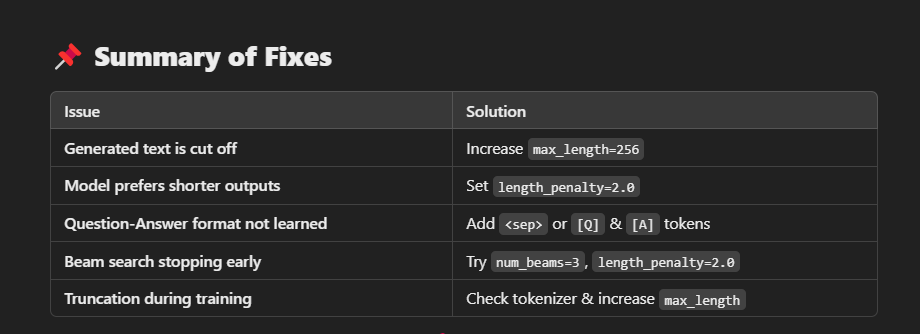

In [60]:
predictions = []
true_labels = []
contexts = []

for example in test_processed[20:40]:
    input_ids = example["input_ids"].unsqueeze(0).to(device)
    attention_mask = example["attention_mask"].unsqueeze(0).to(device)

    # Decode the input context
    context_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    contexts.append(context_text)

    # Extract the true label (ground truth)
    true_label_ids = example["labels"]
    true_label_text = tokenizer.decode(true_label_ids, skip_special_tokens=True)
    true_labels.append(true_label_text)

    # Generate prediction
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=512,
            do_sample = True,
            # num_beams=5,
            # length_penalty=2.0,  # Increase length preference
            top_p = 0.9,
            temperature = 0.7,
            num_return_sequences = 5,
            early_stopping=True
        )

    predicted_text = tokenizer.decode(output_ids[0], skip_special_tokens=True) # try False
    predictions.append(predicted_text)

# Print some sample results
for i, (context, pred, true) in enumerate(zip(contexts[:], predictions[:], true_labels[:])):
    print(f"Example {i+1}:")
    print(f"  Context (Input): {context}")
    print(f"  Prediction: {pred}")
    print(f"  Ground Truth: {true}")
    print("------------")

# Compute BLEU score
bleu_scores = [sentence_bleu([true.split()], pred.split()) for true, pred in zip(true_labels, predictions)]
average_bleu = sum(bleu_scores) / len(bleu_scores)

print(f"BLEU Score: {average_bleu:.4f}")

Example 1:
  Context (Input): ناقشت اللجنة امكانية استخدام وظيفة شيفت كما هو الحال في ITA2 مما يسمح بتمثيل اكثر من 64 رمزا برمز من ست بتات في رمز شيفتيد تحدد بعض رموز الاحرف الاختيارات بين خيارات رموز الاحرف التالية وهو يسمح بتشفير مدمج ولكنه اقل موثوقية لنقل البيانات كخطا في نقل شفرة التغيير يجعل عادة جزءا طويلا من الارسال غير قابل للقراءة قررت لجنة المعايير عدم التغيير ولذلك تطلبت ASCII رمزا على الاقل من سبعة بتات 215 236 4
  Prediction: في ASCII ما هي الرموز التي يمكن تمثيلها في رمز شيفت؟
  Ground Truth: ما هو مختلف في رمز التحول
------------
Example 2:
  Context (Input): ناقشت اللجنة امكانية استخدام وظيفة شيفت كما هو الحال في ITA2 مما يسمح بتمثيل اكثر من 64 رمزا برمز من ست بتات في رمز شيفتيد تحدد بعض رموز الاحرف الاختيارات بين خيارات رموز الاحرف التالية وهو يسمح بتشفير مدمج ولكنه اقل موثوقية لنقل البيانات كخطا في نقل شفرة التغيير يجعل عادة جزءا طويلا من الارسال غير قابل للقراءة قررت لجنة المعايير عدم التغيير ولذلك تطلبت ASCII رمزا على الاقل من سبعة بتات 215 236 4
  Prediction: متى 

In [ ]:
context = "ولد العالم العربي الشهير ابن الهيثم في مدينة البصرة عام 965 ميلادي. كان أحد أبرز العلماء في العصر الذهبي الإسلامي، حيث قدم مساهمات كبيرة في مجالات البصريات، والرياضيات، والهندسة، والفيزياء. يُعتبر كتابه "المناظر" من أهم الكتب التي أثرت في علم البصريات، حيث شرح فيه مبادئ الانعكاس والانكسار، ووضع أسس علم الضوء الحديث. بالإضافة إلى ذلك، كان لابن الهيثم دور مهم في تطوير المنهج العلمي التجريبي، إذ اعتمد على الملاحظة والتجربة لإثبات نظرياته. سافر إلى مصر بدعوة من الخليفة الفاطمي الحاكم بأمر الله، وهناك قام بدراسة سلوك الضوء في الماء والهواء."
input_ids =